<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/TF_CatGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q imageio

In [2]:
import shutil
shutil.unpack_archive("cat_face.zip", "Train")

In [3]:
import tensorflow as tf
import glob
import imageio
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [4]:
 print(tf.__version__)

2.3.0


In [5]:
data_dir = "Train/cats"

In [6]:
batch_size = 512
size = 64
noise_dim = 128

In [7]:
train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  batch_size=batch_size)

Found 15747 files belonging to 1 classes.


In [8]:

preprocesslayers = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(size, size),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [10]:
def preprocess(ds):
  ds=ds.map(lambda data,y: preprocesslayers(data),num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds=ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [11]:
ds_train = preprocess(train)

In [183]:
meow=next(iter(ds_train))[0]

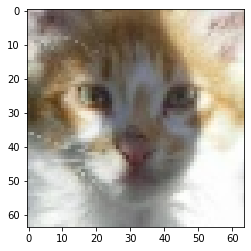

In [184]:
plt.imshow(meow)

In [63]:
def make_generator():
  alpha = 0.2
  model= tf.keras.Sequential([
                              layers.Dense(4*4*256, use_bias=False, input_shape=(noise_dim,)),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              layers.Reshape((4,4,256)),

                              layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(8,8,256)

                              layers.Conv2DTranspose(256,(3,3),strides=(1,1),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(16,16,128)

                              layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(32,32,64)

                              layers.Conv2DTranspose(256,(3,3),strides=(1,1),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(64,64,32)

                              layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(64,64,32)

                              layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding="same",use_bias=False),
                              layers.BatchNormalization(),
                              layers.LeakyReLU(alpha),
                              #(64,64,32)


                              layers.Conv2DTranspose(3,(3,3), strides=(1,1),padding="same",use_bias=False,activation='tanh')

  ])
  
  return model

In [103]:
generator=make_generator()
generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 4096)              524288    
_________________________________________________________________
batch_normalization_57 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 8, 8, 256)         589824    
_________________________________________________________________
batch_normalization_58 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 8, 8, 256)       

In [104]:
def make_discriminator():
  alpha = 0.2
  model=tf.keras.Sequential([layers.GaussianNoise(0.1,input_shape=(64,64,3)),
                             layers.Conv2D(32,(5,5),strides=(2,2),padding='same',input_shape=(64,64,3)),
                             layers.LeakyReLU(alpha),
                             layers.Dropout(0.2),

                             layers.Conv2D(64,(5,5),strides=(2,2),padding='same'),
                             layers.BatchNormalization(),
                             layers.LeakyReLU(alpha),
                             layers.Dropout(0.2),

                             layers.Conv2D(128,(5,5),strides=(2,2),padding='same'),
                             layers.BatchNormalization(),
                             layers.LeakyReLU(alpha),
                             layers.Dropout(0.2),

                             layers.Conv2D(256,(5,5),strides=(2,2),padding='same'),
                             layers.BatchNormalization(),
                             layers.LeakyReLU(alpha),
                             layers.Dropout(0.2),

                             layers.Flatten(),
                             layers.Dense(1,activation="sigmoid")]) #We use from_logits=True
  return model

In [105]:
discriminator = make_discriminator()
discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_7 (GaussianNo (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_64 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 16, 16, 64)      

In [94]:
noise = tf.random.normal([1,noise_dim])
generatedimage=generator(noise,training=False)
decision = discriminator(generatedimage)
print(decision)

tf.Tensor([[0.5000855]], shape=(1, 1), dtype=float32)


#Loss and optimizers

In [95]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
MSE =tf.keras.losses.MeanSquaredError() #For LSGAN

In [171]:
def discriminator_loss(real,fake):
  #takes a tuple of batch of discriminator outputs
  real_loss = MSE(tf.ones_like(real),real) #optimum when predicting all reals to be 1.
  fake_loss = MSE(tf.zeros_like(fake),fake) #optimum when predicting all fakes to be 0.
  return 0.5*real_loss + 0.5*fake_loss

def generator_loss(fake):
  #takes a batch of discriminator outputs
  return MSE(tf.ones_like(fake),fake) #using 0.5 as update as sugested by Hejlm et al. (2017) 

lr = 0.0005
beta1=0.5
generator_optimizer = tf.keras.optimizers.Adam(lr,beta_1=beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr,beta_1=beta1)
#generator_optimizer = tf.keras.optimizers.SGD()
#generator_optimizer = tf.keras.optimizers.SGD()

In [172]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [178]:
EPOCHS = 250
num_examples_to_generate = 16

In [108]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Training loop

In [174]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [175]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_loss=0
    disc_loss=0


    for image_batch in dataset:
      gen_loss_step,disc_loss_step=train_step(image_batch)
      gen_loss += gen_loss_step
      disc_loss+= disc_loss_step
    gen_loss = gen_loss/11776
    disc_loss = disc_loss/11776
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1 + 100, time.time()-start))
    print (f'Generator loss: {gen_loss} Discriminator loss {disc_loss}')

    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)
    plt.plot(gen_losses)
    plt.plot(disc_losses)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs + 100,
                           seed)
  return gen_losses,disc_losses

In [176]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  return predictions

KeyboardInterrupt: ignored

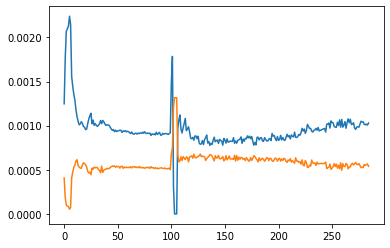

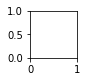

In [179]:
gen_losses,disc_losses= train(ds_train, EPOCHS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


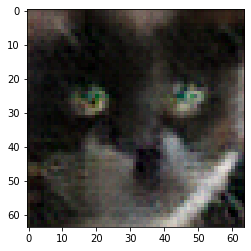

In [188]:
noise = tf.random.normal([16,noise_dim])
generatedimage=generator(noise,training=False)
plt.imshow(generatedimage[0,:,:,:])

In [186]:
generator.save_weights("./Generator_Save")

In [187]:
discriminator = discriminator.save_weights("./Discriminator_Save")